In [4]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


## most recents

In [ ]:
# select run IDs to analyze
run_ids = ["251102_ALLIN_" + str(i) for i in range(5)]

In [ ]:
# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)

    df_result = pd.DataFrame()
    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test)
        df_result = eval.write_metrics_to_df(report, sites, cfg, df=df_result)
        # print("===========================")
        # print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
        #eval.print_all_metrics(report, sites, cfg, above2m=True)
        eval.printout_eval_report(report, sites, cfg, run_id)
        #print("====================================")

    eval.save_df_result_to_csv(df_result, run_id, override=True)


  0%|          | 0/5 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Results saved to ../results/251102_ALLIN_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 40%|████      | 2/5 [00:05<00:08,  2.95s/it]

Results saved to ../results/251102_ALLIN_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

Results saved to ../results/251102_ALLIN_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

Results saved to ../results/251102_ALLIN_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

Results saved to ../results/251102_ALLIN_4/metrics/results_summary.csv


In [99]:
eval.get_aux_metrics(report)

Unique classes in GT Channel 2: [0. 1. 2.]
Length before masking: 175104
Length after masking: 171016
Unique classes in Pred Channel 2: [0. 1. 2.]
Length before masking: 175104
Length after masking: 171016
Auxiliary Metrics:
	F1 Score Channel 1 (Binary): 	0.9814
 	F1 Score Channel 2 (Micro): 	0.9486
----------------------------------------------


(0.9814296976598454, 0.9485662160265707)

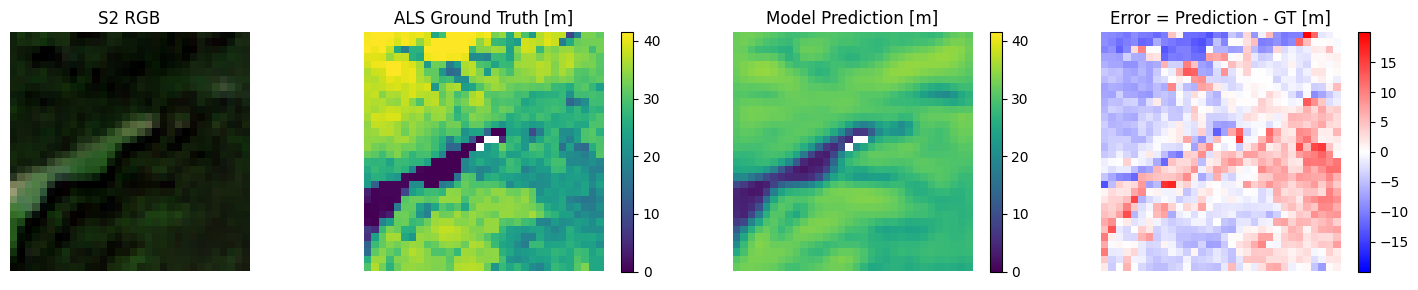

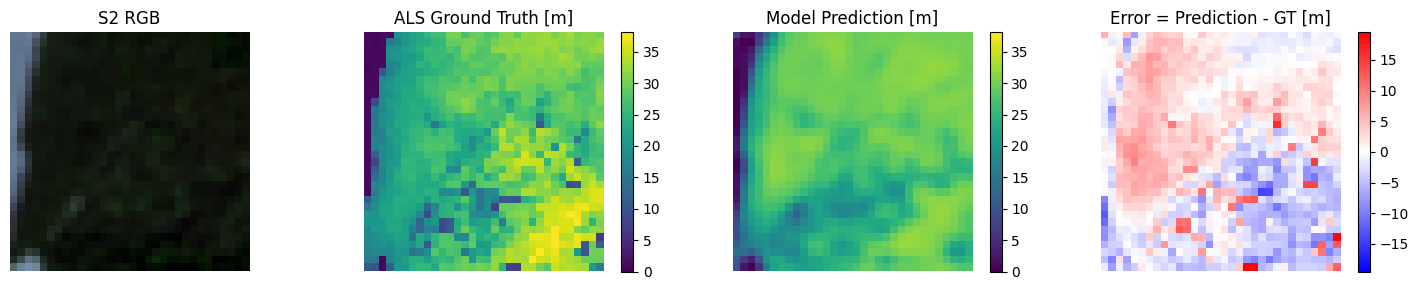

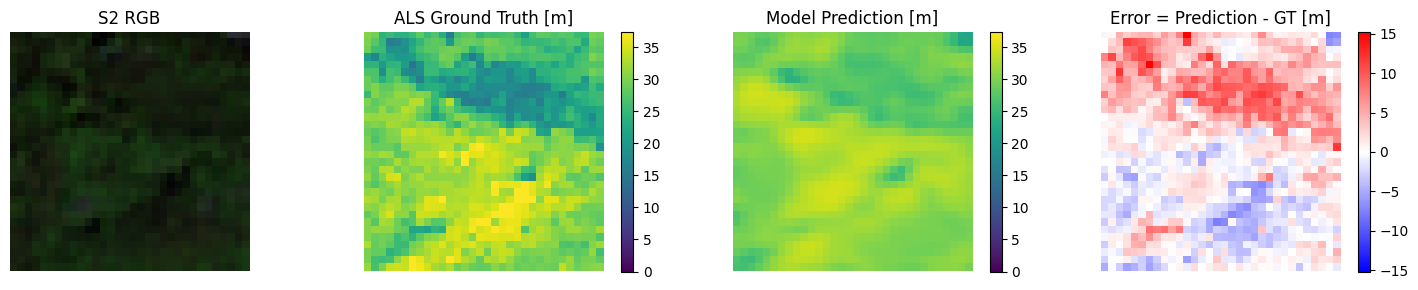

In [263]:
eval.plot_real_pred_delta(report, num_samples=3)

## plot metrics

In [37]:
df_big = eval.read_multiple_csv_to_df(run_ids)


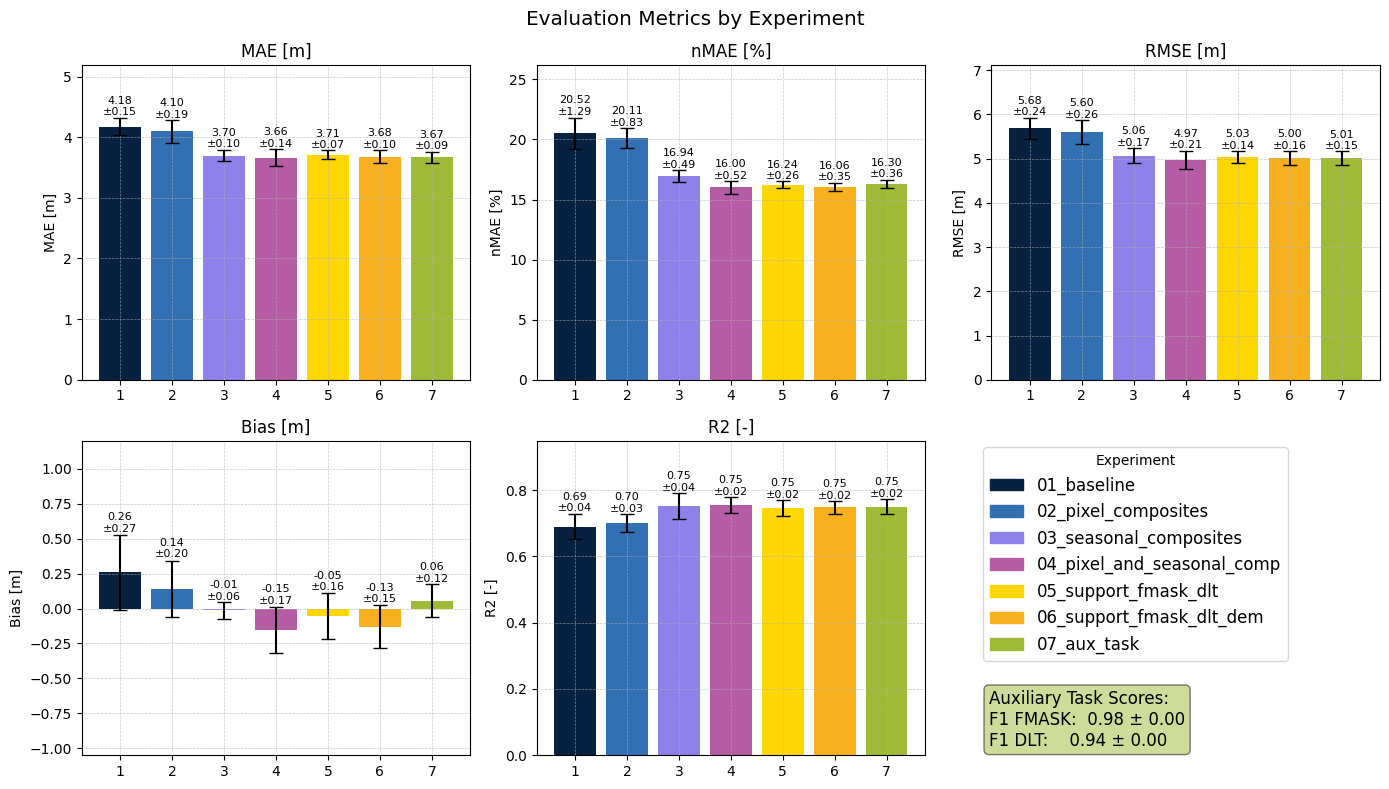

In [38]:
fig, stats = eval.plot_experiment_metrics_multiple_runs(df_result=df_big,printout=False)

## sitewise metrics

In [39]:
from sklearn.metrics import f1_score
dfs = pd.DataFrame()

for run_id in run_ids:
    for exp_name in experiment_names:
        sitecodes = np.load(f"../results/{run_id}/train/{exp_name}/test_site_indices.npz")["site_indices_test"]
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)

        # Compute metrics per site
        for site_id in np.unique(sitecodes):
            site_mask = sitecodes == site_id
            preds_site = preds_test[site_mask, 0, :, :].reshape(-1)
            targets_site = targets_test[site_mask, 0, :, :].reshape(-1)
            mask_site = masktest[site_mask, 0, :, :].reshape(-1).astype(bool)


            # Check if auxiliary task channels exist
            if preds_test.shape[1] > 1 and targets_test.shape[1] > 1:
                # Channel 1: F1 score (binary classification)
                fmask_gt_ch1 = targets_test[site_mask, 1, :, :].flatten()
                #fmask_gt_ch1 = fmask_gt_ch1[mask_site]
                fmask_pred_ch1 = (preds_test[site_mask, 1, :, :].flatten() > 0.5).astype(np.uint8)
                #fmask_pred_ch1 = fmask_pred_ch1[mask_site]
                f1_ch1 = f1_score(fmask_gt_ch1, fmask_pred_ch1, average='binary')

                # Channel 2: Multi-class classification (0, 1, 2)
                fmask_gt_ch2 = targets_test[site_mask, 2, :, :].flatten()
                #fmask_gt_ch2 = fmask_gt_ch2[mask_site]
                fmask_pred_ch2 = preds_test[site_mask, 2, :, :].flatten()
                #fmask_pred_ch2 = fmask_pred_ch2[mask_site]
                f1_micro = f1_score(fmask_gt_ch2, fmask_pred_ch2, average='micro')
            else:
                f1_ch1 = np.nan
                f1_micro = np.nan
            # Keep only unmasked values
            valid_idx = mask_site
            preds_valid = preds_site[valid_idx]
            targets_valid = targets_site[valid_idx]
            
            # Compute metrics
            mae, nmae, rmse, bias, r2 = eval.get_metrics(preds_valid, targets_valid, verbose=False)
            
            # Add to dataframe
            df_tmp = pd.DataFrame({
                "experiment": [exp_name],
                "run_id": [run_id],
                "site_id": [site_id],
                "MAE [m] (Test)": [mae],
                "nMAE [%] (Test)": [nmae],
                "RMSE [m] (Test)": [rmse],
                "Bias [m] (Test)": [bias],
                "R2 [-] (Test)": [r2],
                "F1 FMASK (Test)": [f1_ch1],
                "F1 DLT (Test)": [f1_micro],
                #"seed": [cfg['seed']]
            })
                # Select metrics columns
            metrics = [
                "MAE [m] (Test)",
                "nMAE [%] (Test)",
                "RMSE [m] (Test)", 
                "Bias [m] (Test)",
                "R2 [-] (Test)",
                "F1 FMASK (Test)",
                "F1 DLT (Test)"
            ]   
            
            dfs = pd.concat([dfs, df_tmp], ignore_index=True)



In [40]:
# melt the df, we want to group by experiment and site_id, aggregating mean and std
dfmelt = dfs.melt(id_vars=["experiment", "site_id"], value_vars=metrics, var_name="metric", value_name="value")
dfmelt = dfmelt.groupby(["experiment", "site_id", "metric"])["value"].agg(["mean", "std"]).reset_index()
dfmelt.columns = ["experiment", "site_id", "metric", "mean", "std"]

path = "../results/all_in/final/metrics/sitewise_metrics_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)
dfmelt.to_csv(path)
print("Site-wise metrics summary saved to", path)

Site-wise metrics summary saved to ../results/all_in/final/metrics/sitewise_metrics_summary.csv


Plot saved to ../results/all_in/final/plots/sitewise_metrics/MAE_m_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/nMAE_%_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/RMSE_m_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/Bias_m_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/R2_-_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/F1_FMASK_Test_boxplot.pdf
Plot saved to ../results/all_in/final/plots/sitewise_metrics/F1_DLT_Test_boxplot.pdf


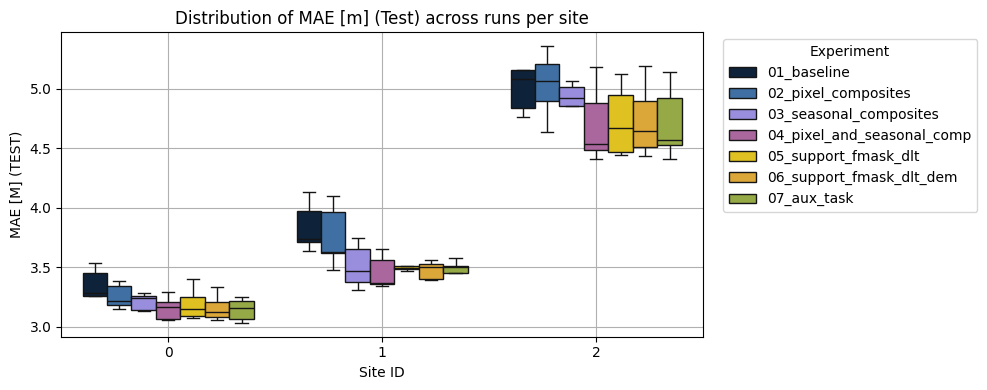

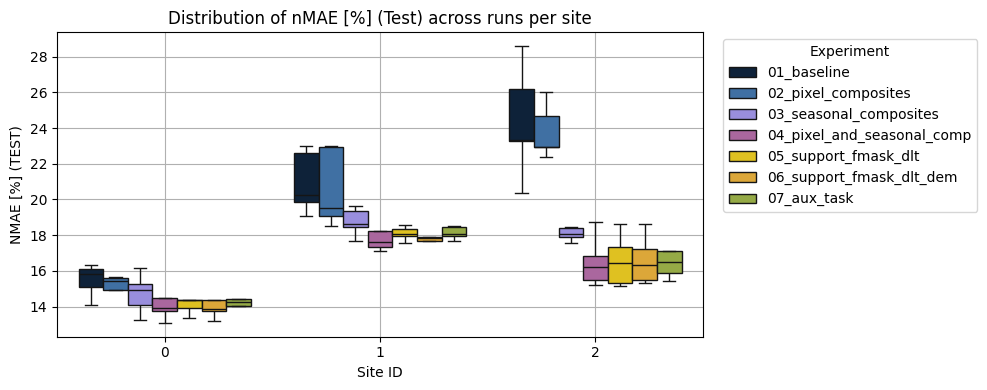

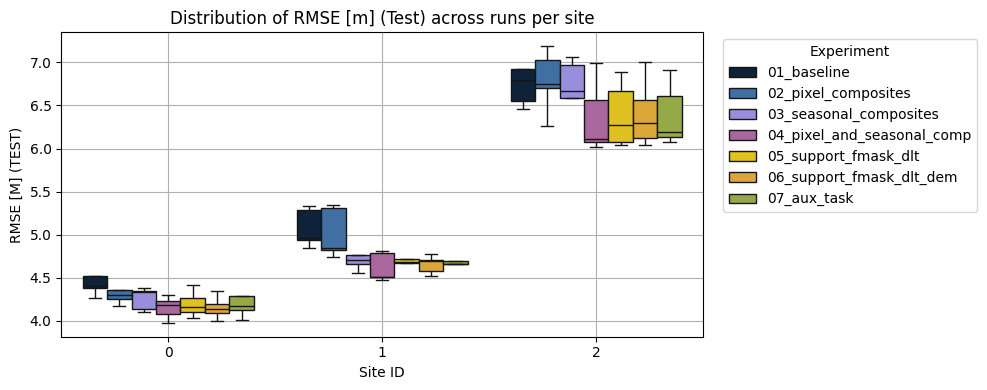

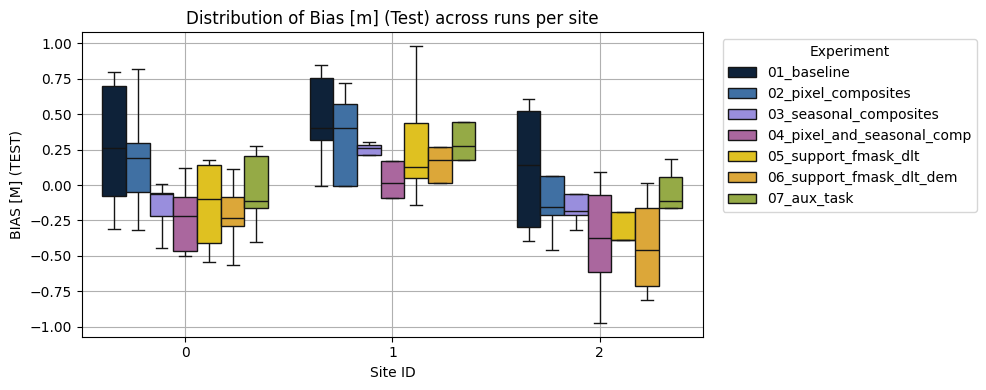

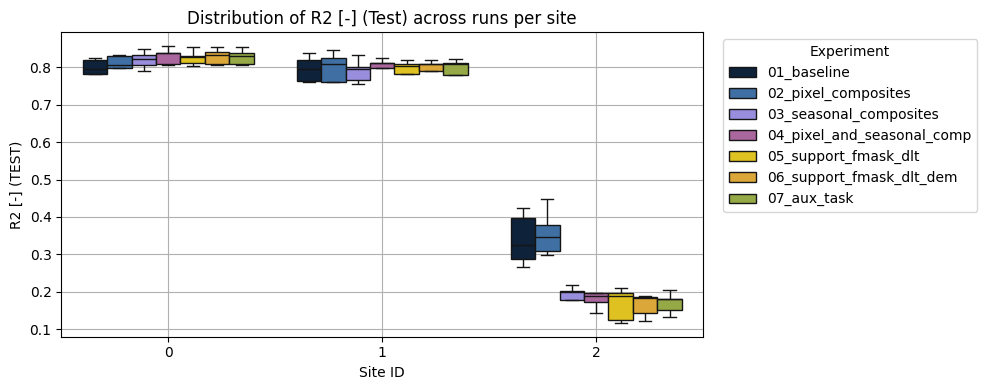

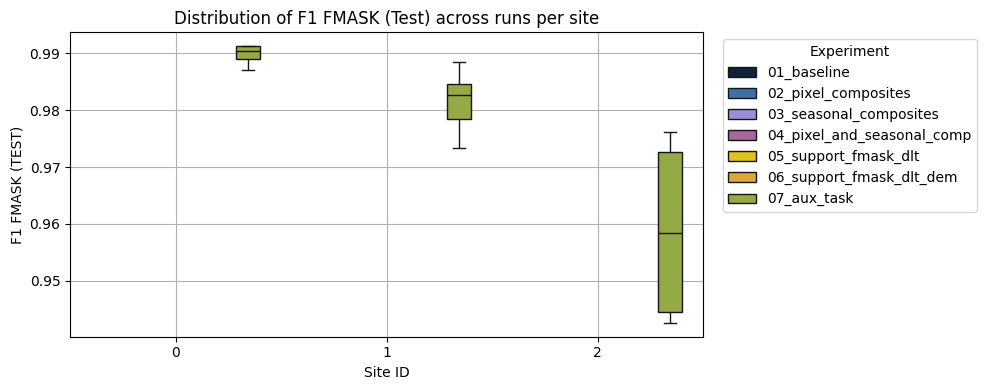

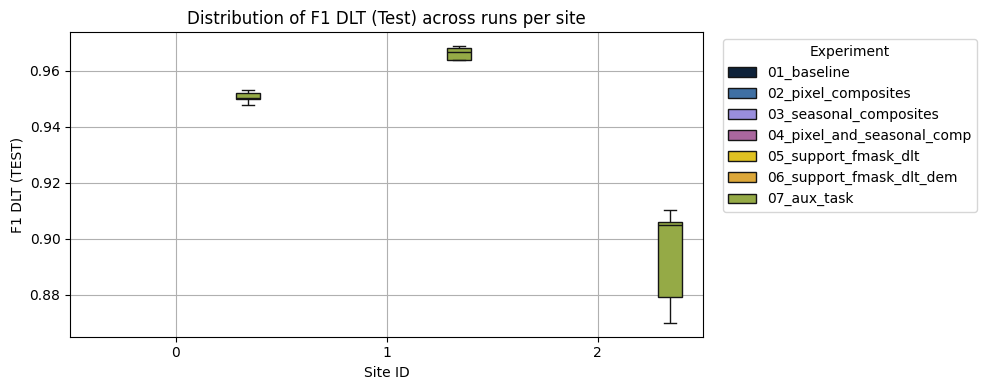

In [81]:
import seaborn as sns
# now for each esperiment and site, plot boxplots of mae, nmae, rmse, bias, r2 across runs
metrics = [
    "MAE [m] (Test)",
    "nMAE [%] (Test)",
    "RMSE [m] (Test)", 
    "Bias [m] (Test)",
    "R2 [-] (Test)",
    "F1 FMASK (Test)",
    "F1 DLT (Test)"
]  
# Custom color palette
palette = [0x072140, 0x3070B3, 0x8F81EA, 0xB55CA5, 0xFED702, 0xF7B11E, 0x9FBA36]
palette = [f'#{color:06X}' for color in palette]
exp_names = dfs['experiment'].unique()

basepath = "../results/all_in/final/plots/sitewise_metrics/"
os.makedirs(basepath, exist_ok=True)

exp_palette = {exp: palette[i % len(palette)] for i, exp in enumerate(exp_names)}
for metric in metrics:
    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    #sns.barplot(data=dfs, x="site_id", y=metric, hue="experiment", ax=ax, errorbar="sd", palette=exp_palette)
    sns.boxplot(data=dfs, x="site_id", y=metric, hue="experiment", ax=ax, palette=exp_palette, showfliers=False)
    plt.title(f"Distribution of {metric} across runs per site")
    plt.xlabel("Site ID")
    plt.ylabel(metric.upper())
    plt.legend(title="Experiment", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.grid()
    #plt.show()
    savepath = os.path.join(basepath, f"{metric.replace(' ', '_').replace('[','').replace(']','').replace('(','').replace(')','')}_boxplot.pdf")
    plt.savefig(savepath)
    print("Plot saved to", savepath)

## joint plots

In [49]:
#run_ids= ["251024_FINAL_" + str(i) for i in range(5)]
run_ids

['251102_ALLIN_0',
 '251102_ALLIN_1',
 '251102_ALLIN_2',
 '251102_ALLIN_3',
 '251102_ALLIN_4']

In [26]:
#run_ids= ["251024_FINAL_" + str(i) for i in range(5)]
#run_ids = ["251028_PATCHSYNC_0"]
dfall = pd.DataFrame()  # cols: experiment, preds, targets, run_id
dfpatch = pd.DataFrame() #keeps the patch structure.

# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)

    # Prepare lists to collect all predictions, targets, and experiment names across all runs
    if 'all_preds' not in locals():
        all_preds = []
        all_targets = []
        all_exp_names = []
        all_run_ids = []

    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        # Take only the first channel [:,0,:,:], flatten, and drop masked values
        preds_flat = preds_test[:, 0, :, :].reshape(-1)
        targets_flat = targets_test[:, 0, :, :].reshape(-1)
        mask_flat = masktest[:, 0, :, :].reshape(-1).astype(bool)
        # Keep only unmasked values (mask==1)
        valid_idx = mask_flat
        preds_valid = preds_flat[valid_idx]
        targets_valid = targets_flat[valid_idx]

        # Append to dfall DataFrame with current exp_name and run_id
        df_tmp = pd.DataFrame({
            "experiment": exp_name,
            "run_id": run_id,
            "preds": preds_valid,
            "targets": targets_valid, 
            'seed': cfg['seed']
        })
        dfall = pd.concat([dfall, df_tmp], ignore_index=True)

        # fill dfpatch like with dfall, but it shall keep the shape of the patch (last two dims are 32x32). so a df, with N samples per run_id and exp name. each object has the shape (1,32,32)
        # preds_test, targets_test, masktest shape: (N, 1, 32, 32)
        # We'll keep only unmasked patches (mask==1 for all elements in patch)
        n_patches = preds_test.shape[0]
        for i in range(n_patches):
            patch_mask = masktest[i, 0, :, :]
            if 1:  # keep patches with at least some valid pixels
                patch_pred = preds_test[i, 0, :, :]
                patch_target = targets_test[i, 0, :, :]
                patch_mask_bool = patch_mask.astype(bool)
                dfpatch = pd.concat([
                    dfpatch,
                    pd.DataFrame({
                    "experiment": [exp_name],
                    "run_id": [run_id],
                    "PatchNum": i,
                    "preds_patch": [patch_pred.copy()],
                    "targets_patch": [patch_target.copy()],
                    "mask_patch": [patch_mask_bool.copy()],
                    "rgb_patch": [rgb_test[i,:,:,:].copy()],
                    "seed": [cfg['seed']]
                    })
                ], ignore_index=True)


  0%|          | 0/5 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 40%|████      | 2/5 [00:01<00:02,  1.36it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


In [50]:
dfpatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6410 entries, 0 to 6409
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   experiment     6410 non-null   object
 1   run_id         6410 non-null   object
 2   PatchNum       6410 non-null   int64 
 3   preds_patch    6410 non-null   object
 4   targets_patch  6410 non-null   object
 5   mask_patch     6410 non-null   object
 6   rgb_patch      6410 non-null   object
 7   seed           6410 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 400.8+ KB


In [51]:
dfsub = dfall[dfall['run_id'] == '251102_ALLIN_0']

### residuals over gt

In [29]:
import pandas as pd

def plot_residuals_nmae_bias_vs_gt(df, bins=50, title="Residuals, nMAE, Bias vs. GT Distribution"):
    """
    Plot 3 subplots: 1) MAE (residuals), 2) nMAE, 3) Bias, each vs. ground truth, 
    with scaled GT distribution overlay. 
    The GT distribution is scaled to the max of the respective metric.
    Additional row: boxplots of metrics for selected experiments across GT bins (hued by experiment).
    """
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    palette = ['#072140', '#3070B3', '#8F81EA', '#B55CA5', '#FED702', '#F7B11E', '#9FBA36']
    
    experiments = df['experiment'].unique()
    subset_exp = ['01_baseline', '04_pixel_and_seasonal', '06_support_fmask_dlt_dem', '07_aux_task']
    selected_experiments = [e for e in experiments if any(x in e for x in experiments )]
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    gt_all = df['targets'].values
    hist_gt, bin_edges_gt = np.histogram(gt_all, bins=bins, range=(0, 50))
    hist_gt = hist_gt / hist_gt.max()
    bin_centers_gt = (bin_edges_gt[:-1] + bin_edges_gt[1:]) / 2

    max_mae, max_nmae, max_bias, min_bias = 0, 0, 0, 0
    metrics = {exp: {} for exp in experiments}

    for exp in experiments:
        sub = df[df['experiment'] == exp]
        preds = sub['preds'].values
        targets = sub['targets'].values
        errors = preds - targets

        bin_mae, bin_edges, _ = stats.binned_statistic(targets, abs(errors), statistic='mean', bins=bins)
        bin_counts, _, _ = stats.binned_statistic(targets, targets, statistic='count', bins=bin_edges)
        mask = bin_counts < 10
        bin_mae[mask] = np.nan
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_mae = max(max_mae, np.nanquantile(bin_mae, 0.9))
        metrics[exp]['mae'] = (bin_centers, bin_mae)

        mask_range = (targets >= 2) & (targets <= 60)
        nmae = (np.abs(errors[mask_range]) / targets[mask_range]) * 100
        bin_nmae, bin_edges_nmae, _ = stats.binned_statistic(targets[mask_range], nmae, statistic='mean', bins=bins)
        bin_counts_nmae, _, _ = stats.binned_statistic(targets[mask_range], targets[mask_range], statistic='count', bins=bin_edges_nmae)
        mask_nmae = bin_counts_nmae < 10
        bin_nmae[mask_nmae] = np.nan
        bin_centers_nmae = (bin_edges_nmae[:-1] + bin_edges_nmae[1:]) / 2
        max_nmae = max(max_nmae, np.nanmax(bin_nmae))
        metrics[exp]['nmae'] = (bin_centers_nmae, bin_nmae)

        bin_bias, bin_edges_bias, _ = stats.binned_statistic(targets, errors, statistic='mean', bins=bins)
        bin_counts_bias, _, _ = stats.binned_statistic(targets, targets, statistic='count', bins=bin_edges_bias)
        mask_bias = bin_counts_bias < 10
        bin_bias[mask_bias] = np.nan
        bin_centers_bias = (bin_edges_bias[:-1] + bin_edges_bias[1:]) / 2
        max_bias = max(max_bias, np.nanquantile(np.abs(bin_bias), 0.9))
        min_bias = min(min_bias, np.nanquantile(bin_bias, 0.1))
        metrics[exp]['bias'] = (bin_centers_bias, bin_bias)

    # Plot lines with palette for selected_experiments, gray for others
    handles = []
    labels = []
    for idx, exp in enumerate(experiments):
        color = palette[selected_experiments.index(exp)] if exp in selected_experiments else 'gray'
        l0, = axes[0, 0].plot(*metrics[exp]['mae'], label=exp, color=color)
        l1, = axes[0, 1].plot(*metrics[exp]['nmae'], label=exp, color=color)
        l2, = axes[0, 2].plot(*metrics[exp]['bias'], label=exp, color=color)
        if exp in selected_experiments:
            handles.append(l0)
            labels.append(exp)

    dist = axes[0, 0].plot(bin_centers_gt, hist_gt * max_mae, '--', color='lightgray', label='GT dist (scaled)')
    axes[0, 1].plot(bin_centers_gt, hist_gt * max_nmae, '--', color='lightgray', label='GT dist (scaled)')
    axes[0, 2].plot(bin_centers_gt, hist_gt * max_bias, '--', color='lightgray', label='GT dist (scaled)')
    handles.append(dist[0])
    labels.append("GT density (scaled)")

    axes[0, 0].set_xlabel('Ground Truth [m]')
    axes[0, 0].set_ylabel('MAE [m]')
    axes[0, 0].set_title('MAE vs. Ground Truth')
    axes[0, 0].grid(True)
    axes[0, 0].set_xlim(0, 50)
    axes[0, 0].set_ylim(0, max_mae)

    axes[0, 1].set_xlabel('Ground Truth [m]')
    axes[0, 1].set_ylabel('nMAE [%]')
    axes[0, 1].set_title('NMAE vs. Ground Truth')
    axes[0, 1].grid(True)
    axes[0, 1].set_xlim(0, 50)
    axes[0, 1].set_ylim(0, max_nmae)

    axes[0, 2].set_xlabel('Ground Truth [m]')
    axes[0, 2].set_ylabel('Bias [m]')
    axes[0, 2].set_title('Bias vs. Ground Truth')
    axes[0, 2].grid(True)
    axes[0, 2].set_xlim(0, 50)
    axes[0, 2].set_ylim(min_bias, max_bias)

    gt_bins = [5, 15, 25, 35, 45]
    gt_labels = ['5-15', '15-25', '25-35', '35-45']

    for metric_idx, metric_name in enumerate(['mae', 'nmae', 'bias']):
        boxplot_data = []
        
        for gt_bin_idx, (bin_low, bin_high) in enumerate(zip(gt_bins[:-1], gt_bins[1:])):
            for exp in selected_experiments:
                sub = df[df['experiment'] == exp]
                preds = sub['preds'].values
                targets = sub['targets'].values
                errors = preds - targets

                if metric_name == 'mae':
                    values = np.abs(errors)
                elif metric_name == 'nmae':
                    mask_range = (targets >= 2) & (targets <= 60)
                    values = (np.abs(errors[mask_range]) / targets[mask_range]) * 100
                    targets = targets[mask_range]
                else:
                    values = errors

                mask = (targets >= bin_low) & (targets < bin_high)
                if mask.sum() > 0:
                    for val in values[mask]:
                        boxplot_data.append({'value': val, 'gt_bin': gt_labels[gt_bin_idx], 'experiment': exp})

        boxplot_df = pd.DataFrame(boxplot_data)
        sns.boxplot(data=boxplot_df, x='gt_bin', y='value', hue='experiment', ax=axes[1, metric_idx],
                    palette=palette[:len(selected_experiments)], showfliers=False)
        axes[1, metric_idx].set_xlabel('Ground Truth Bin [m]')
        axes[1, metric_idx].set_ylabel(('MAE [m]' if metric_name == 'mae' else 
                                         'nMAE [%]' if metric_name == 'nmae' else 'Bias [m]'))
        axes[1, metric_idx].set_title(f'{metric_name.upper()} Statistics by GT Bin')
        axes[1, metric_idx].grid(True, alpha=0.3, axis='y')
        axes[1, metric_idx].legend_.remove()  # Remove individual legends
    
    #axes[0,2] add a black line at y=0
    axes[0,2].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1,2].axhline(0, color='black', linestyle='-', linewidth=1)


    axes[1,0].set_ylim(0,30)
    axes[1,1].set_ylim(0,120)
    # One legend for all, outside on the right
    #fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.005, 0.5), borderaxespad=0., title='Experiment')
    title = "MAE, nMAE, Bias vs. GT Distribution \n dashed line: GT CHM density (scaled)"
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    return fig


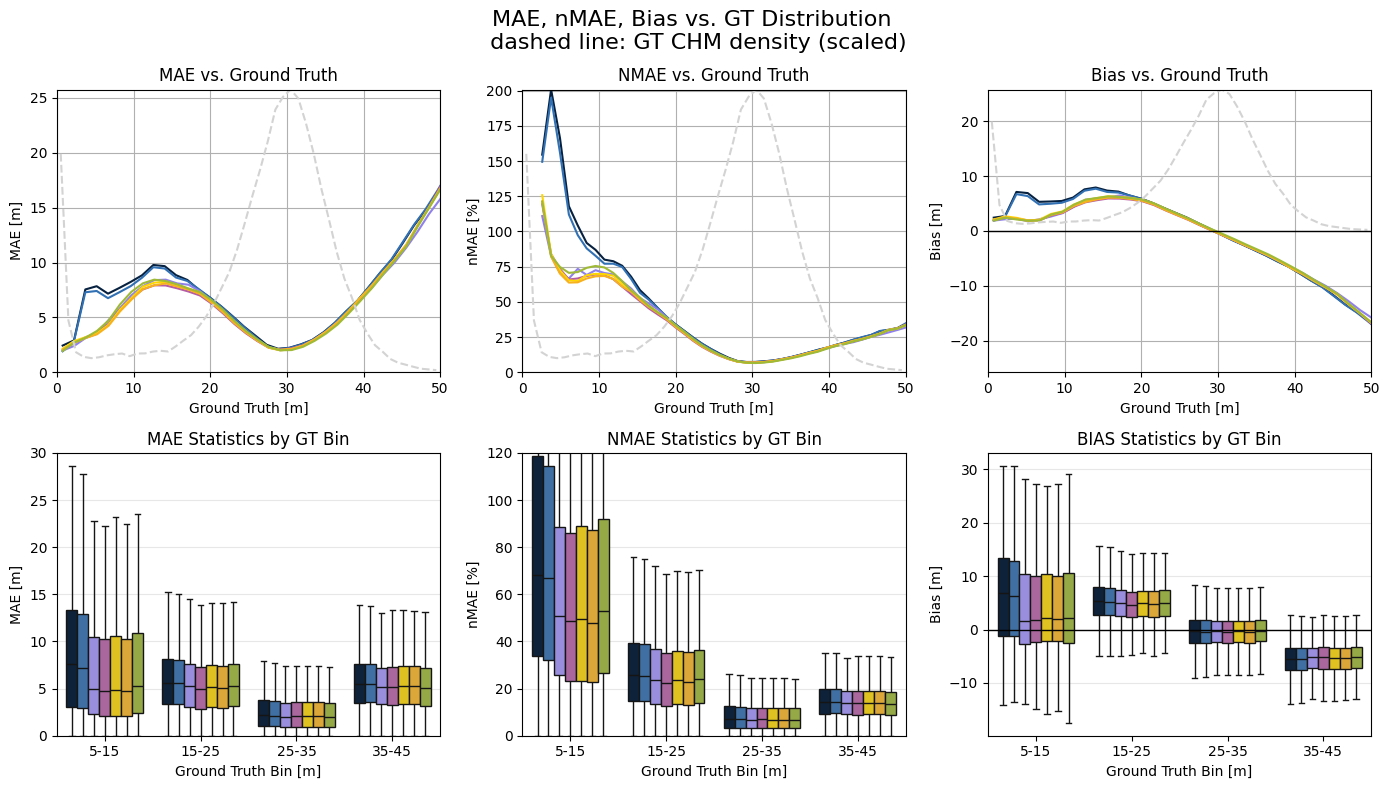

In [52]:
fig = plot_residuals_nmae_bias_vs_gt(dfall,title="Metrics vs. Ground Truth CHM")
fig.savefig("../results/all_in/final/metrics_vs_gt_all_runs.pdf", dpi=300, bbox_inches='tight')


### scatter heatmap

/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_37599/3433118200.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


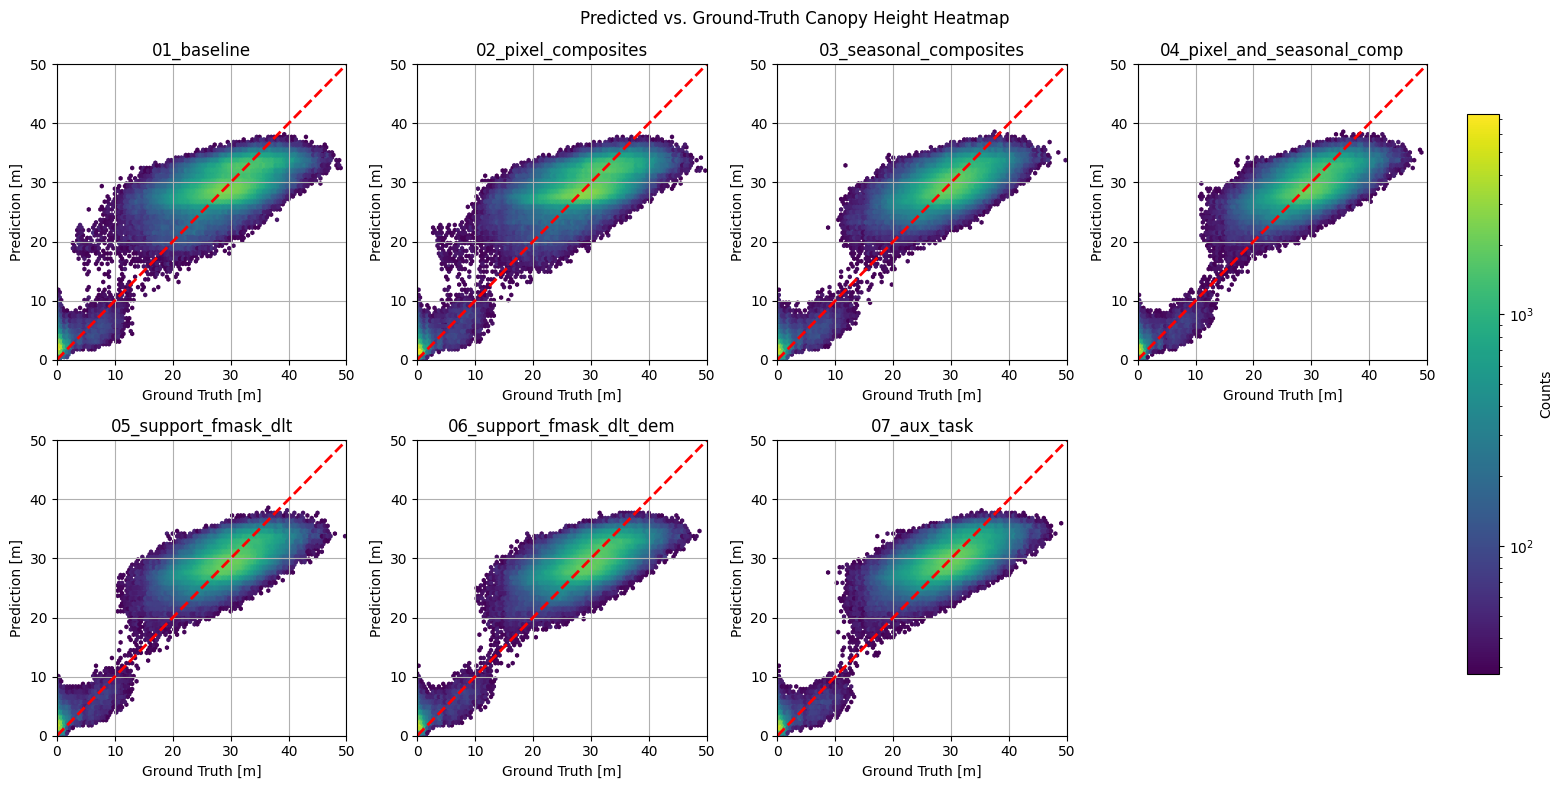

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume dfall exists as in previous cells, with columns: "experiment", "preds", "targets"
experiments = dfall['experiment'].unique()
n_exp = len(experiments)
ncols = min(4, n_exp)
nrows = (n_exp + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

# Find global min and max counts across all experiments
global_vmin, global_vmax = 28, 0
for exp in experiments:
    sub = dfall[dfall['experiment'] == exp]
    hb_temp = axes[0, 0].hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, extent=(0, 50, 0, 50), mincnt=global_vmin
    )
    counts = hb_temp.get_array()
    if len(counts) > global_vmin:
        global_vmin = min(global_vmin, counts.min())
        global_vmax = max(global_vmax, counts.max())
    hb_temp.remove()

# Ensure log scale applies correctly
global_vmin = max(global_vmin, 1)  # Avoid log(0)

for idx, exp in enumerate(experiments):
    ax = axes[idx // ncols, idx % ncols]
    sub = dfall[dfall['experiment'] == exp]
    hb = ax.hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, cmap='viridis', bins='log', extent=(0, 50, 0, 50),
        mincnt=global_vmin, vmin=global_vmin, vmax=global_vmax
    )
    # Add ideal line y=x
    ax.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2, label='Ideal')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_title(exp)
    ax.set_xlabel('Ground Truth [m]')
    ax.set_ylabel('Prediction [m]')
    ax.grid(True)

# Add single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=global_vmin, vmax=global_vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Counts')

plt.suptitle("Predicted vs. Ground-Truth Canopy Height Heatmap")

# Hide any unused subplots
for i in range(n_exp, nrows * ncols):
    axes[i // ncols, i % ncols].axis('off')

plt.tight_layout(rect=[0, 0, 0.91, 1])
path = "../results/all_in/final/plots/scatter_density.pdf" 
fig.savefig(path)

plt.show()

# all runs 

/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_37599/3179561365.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


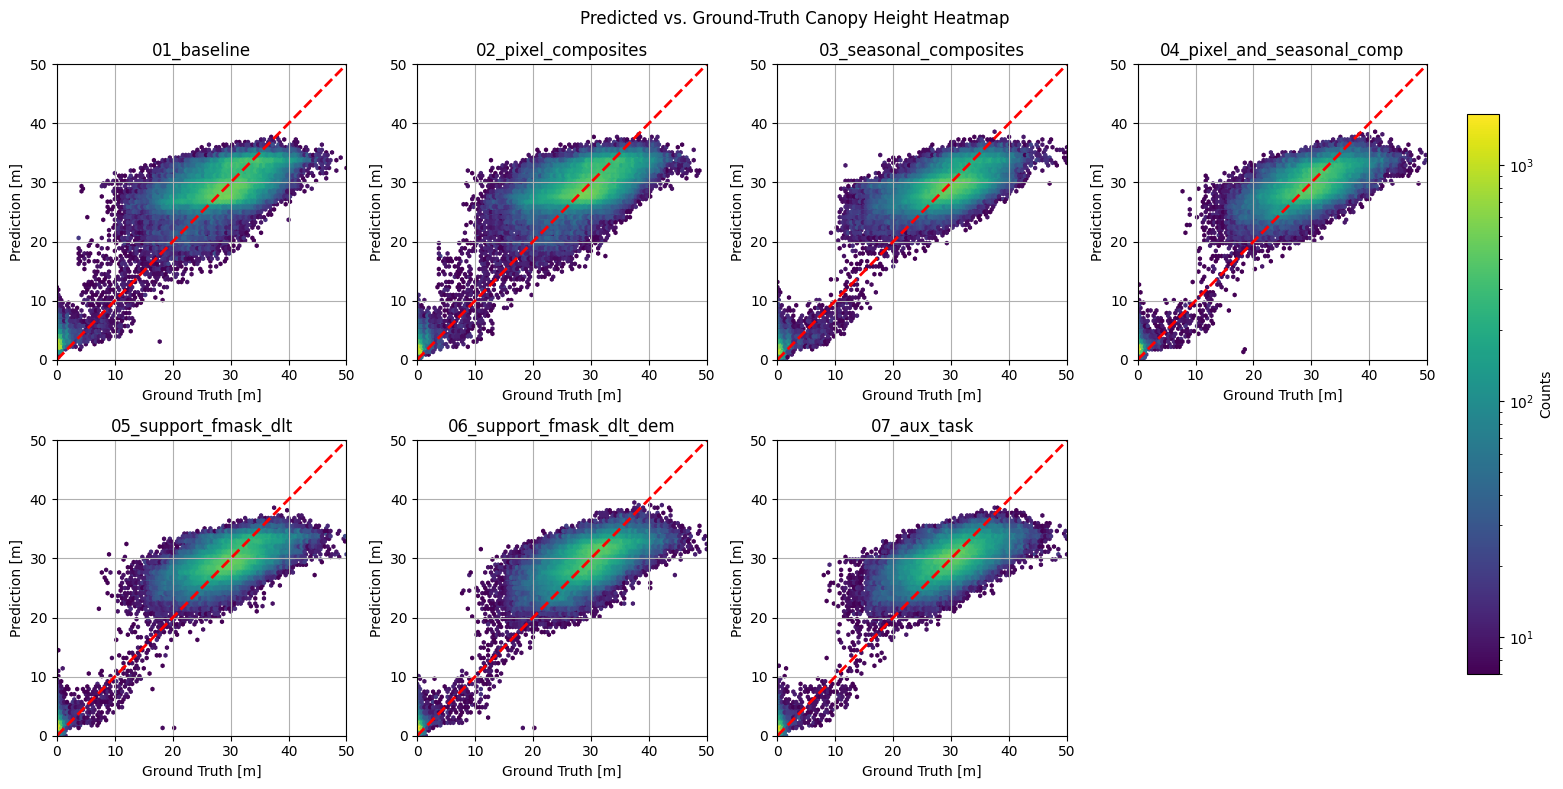

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_temp = dfsub.copy()

# Assume dfall exists as in previous cells, with columns: "experiment", "preds", "targets"
experiments = df_temp['experiment'].unique()
n_exp = len(experiments)
ncols = min(4, n_exp)
nrows = (n_exp + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

# Find global min and max counts across all experiments
global_vmin, global_vmax = 7, 0
for exp in experiments:
    sub = df_temp[df_temp['experiment'] == exp]
    hb_temp = axes[0, 0].hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, extent=(0, 50, 0, 50), mincnt=global_vmin
    )
    counts = hb_temp.get_array()
    if len(counts) > global_vmin:
        global_vmin = min(global_vmin, counts.min())
        global_vmax = max(global_vmax, counts.max())
    hb_temp.remove()

# Ensure log scale applies correctly
global_vmin = max(global_vmin, 1)  # Avoid log(0)

for idx, exp in enumerate(experiments):
    ax = axes[idx // ncols, idx % ncols]
    sub = df_temp[df_temp['experiment'] == exp]
    hb = ax.hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, cmap='viridis', bins='log', extent=(0, 50, 0, 50),
        mincnt=global_vmin, vmin=global_vmin, vmax=global_vmax
    )
    # Add ideal line y=x
    ax.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2, label='Ideal')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_title(exp)
    ax.set_xlabel('Ground Truth [m]')
    ax.set_ylabel('Prediction [m]')
    ax.grid(True)

# Add single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=global_vmin, vmax=global_vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Counts')

plt.suptitle("Predicted vs. Ground-Truth Canopy Height Heatmap")

# Hide any unused subplots
for i in range(n_exp, nrows * ncols):
    axes[i // ncols, i % ncols].axis('off')

plt.tight_layout(rect=[0, 0, 0.91, 1])
path = "../results/all_in/final/plots/scatter_density_firstrun.pdf" 
fig.savefig(path)

plt.show()



# Patch Overlays

In [427]:
def plot_patch_across_experiments(dfpatch, run_id, patch_id):
    """
    For a given run_id and patch_id, plot S2 RGB, ALS GT, Prediction, and Error
    for each experiment (one row per experiment).
    """
    experiments = dfpatch['experiment'].unique()
    n_exp = len(experiments)
    fig, axes = plt.subplots(n_exp, 4, figsize=(16, 4 * n_exp))

    for i, exp in enumerate(experiments):
        row = dfpatch[(dfpatch['experiment'] == exp) & 
                      (dfpatch['run_id'] == run_id) & 
                      (dfpatch['PatchNum'] == patch_id)]
        if row.empty:
            for j in range(4):
                axes[i, j].axis('off')
            continue
        
        rgb = row['rgb_patch'].values[0]
        rgb = row['rgb_patch'].values[0] if 'rgb_patch' in row else np.zeros((32,32,3))
        if rgb.shape == (3, 32, 32):
            rgb = np.transpose(rgb, (1, 2, 0))
        pred = row['preds_patch'].values[0]
        target = row['targets_patch'].values[0]
        mask = row['mask_patch'].values[0]

        # S2 RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"{exp} - S2 RGB")
        axes[i, 0].axis('off')

        # ALS GT
        min_val = 0
        max_val = np.nanmax(target) * 0.95
        im1 = axes[i, 1].imshow(np.where(mask, target, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 1].set_title("ALS Ground Truth [m]")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1])

        # Prediction
        im2 = axes[i, 2].imshow(np.where(mask, pred, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 2].set_title("Model Prediction [m]")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2])

        # Error
        delta = np.where(mask, pred - target, np.nan)
        vmax = np.nanmax(np.abs(delta))
        im3 = axes[i, 3].imshow(delta, cmap='bwr', vmin=-vmax, vmax=vmax)
        axes[i, 3].set_title("Error = Prediction - GT [m]")
        axes[i, 3].axis('off')
        plt.colorbar(im3, ax=axes[i, 3])

    plt.tight_layout()
    plt.show()


In [55]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_first_n_patches(dfpatch, n=10):
    """
    Plot the first n patches in dfpatch, each row: S2 RGB, ALS GT, Prediction, Error.
    Suptitle for each row: experiment name and patch id.
    """
    n = min(n, len(dfpatch))
    fig, axes = plt.subplots(n, 4, figsize=(16, 4 * n))
    if n == 1:
        axes = axes[None, :]  # Ensure axes is always 2D

    for i in range(n):
        row = dfpatch.iloc[i]
        exp = row['experiment']
        patch_id = row['PatchNum']
        rgb = row['rgb_patch']
        rgb = rgb
        if rgb.shape == (3, 32, 32):
            rgb = np.transpose(rgb, (1, 2, 0))
        pred = row['preds_patch']
        target = row['targets_patch']
        mask = row['mask_patch']

        # S2 RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("S2 RGB")
        # Set experiment name and patch id as ylabel on the RGB axis
        axes[i, 0].set_ylabel(f"{exp}\nPatch {patch_id}", fontsize=12, rotation=90, labelpad=25, va='center')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].tick_params(labelleft=False, labelbottom=False)

        cbshrink= 0.041

        # ALS GT
        min_val = 0
        max_val = np.nanmax(target) * 0.95
        im1 = axes[i, 1].imshow(np.where(mask, target, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 1].set_title("ALS Ground Truth [m]")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1],fraction=cbshrink, pad=0.04)

        # Prediction
        im2 = axes[i, 2].imshow(np.where(mask, pred, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 2].set_title("Model Prediction [m]")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2],fraction=cbshrink, pad=0.04)

        # Error
        delta = np.where(mask, pred - target, np.nan)
        vmax = np.nanmax(np.abs(delta))
        im3 = axes[i, 3].imshow(delta, cmap='bwr', vmin=-vmax, vmax=vmax)
        axes[i, 3].set_title("Error = Prediction - GT [m]")
        axes[i, 3].axis('off')
        plt.colorbar(im3, ax=axes[i, 3],location="right", fraction=cbshrink, pad=0.04)


    plt.tight_layout()
    return fig
    #plt.show()


In [ ]:
#plot_first_n_patches(dfpatch=dfpatch, n=3)

In [78]:
def findgoodpatches(dfpatch, topk=1):
    """
    Return a filtered dfpatch with the top `topk` rows for each experiment.
    Top patches are selected by highest std in ground truth (targets_patch) and lowest mean error (abs(pred-gt)).
    """
    dfs = []
    blacklist = [209, 89, 111, 13, 102, 126, 141, 110, 136, 170, 171, 38]#[13,131,141]
    for exp in dfpatch['experiment'].unique():
        sub = dfpatch[dfpatch['experiment'] == exp].copy()
        # Compute std of ground truth and mean error for each patch
        # Compute std of ground truth and mean error for each patch, using only valid (non-nan) pixels
        def valid_mask(x):
            return ~np.isnan(x)
        def nan_rate(x):
            return np.isnan(x).sum() / x.size
        sub['target_std'] = sub['targets_patch'].apply(lambda x: np.nanstd(x))
        sub['mean_error'] = sub.apply(lambda row: np.nanmean(np.abs(row['preds_patch'] - row['targets_patch'])), axis=1)
        sub['nan_rate'] = sub['targets_patch'].apply(nan_rate)
        # Only keep patches with less than 10% nan rate
        sub = sub[sub['nan_rate'] == 0.0]
        # Normalize both metrics to [0, 1] for equal weighting
        if len(sub) > 0:
            std_norm = (sub['target_std'] - sub['target_std'].min()) / (sub['target_std'].max() - sub['target_std'].min() + 1e-8)
            err_norm = (sub['mean_error'] - sub['mean_error'].min()) / (sub['mean_error'].max() - sub['mean_error'].min() + 1e-8)
            # Higher std is better, lower error is better
            sub['score'] = std_norm + (1 - err_norm)
            sub = sub.sort_values('score', ascending=False)
            # If PatchNum is not unique (e.g., due to concat from multiple runs), keep only the first occurrence
            if "PatchNum" in sub.columns:
                # Only keep rows whose PatchNum is not already in dfs
                existing_patchnums = set()
                for d in dfs:
                    if "PatchNum" in d.columns:
                        existing_patchnums.update(d["PatchNum"].tolist())
                sub = sub[~sub["PatchNum"].isin(existing_patchnums)]
                sub = sub[~sub["PatchNum"].isin(blacklist)]
                sub = sub.drop_duplicates(subset=["PatchNum"])
            sub = sub.head(topk)
        dfs.append(sub)
    return pd.concat(dfs, ignore_index=True)


In [79]:
dftop = findgoodpatches(dfpatch)

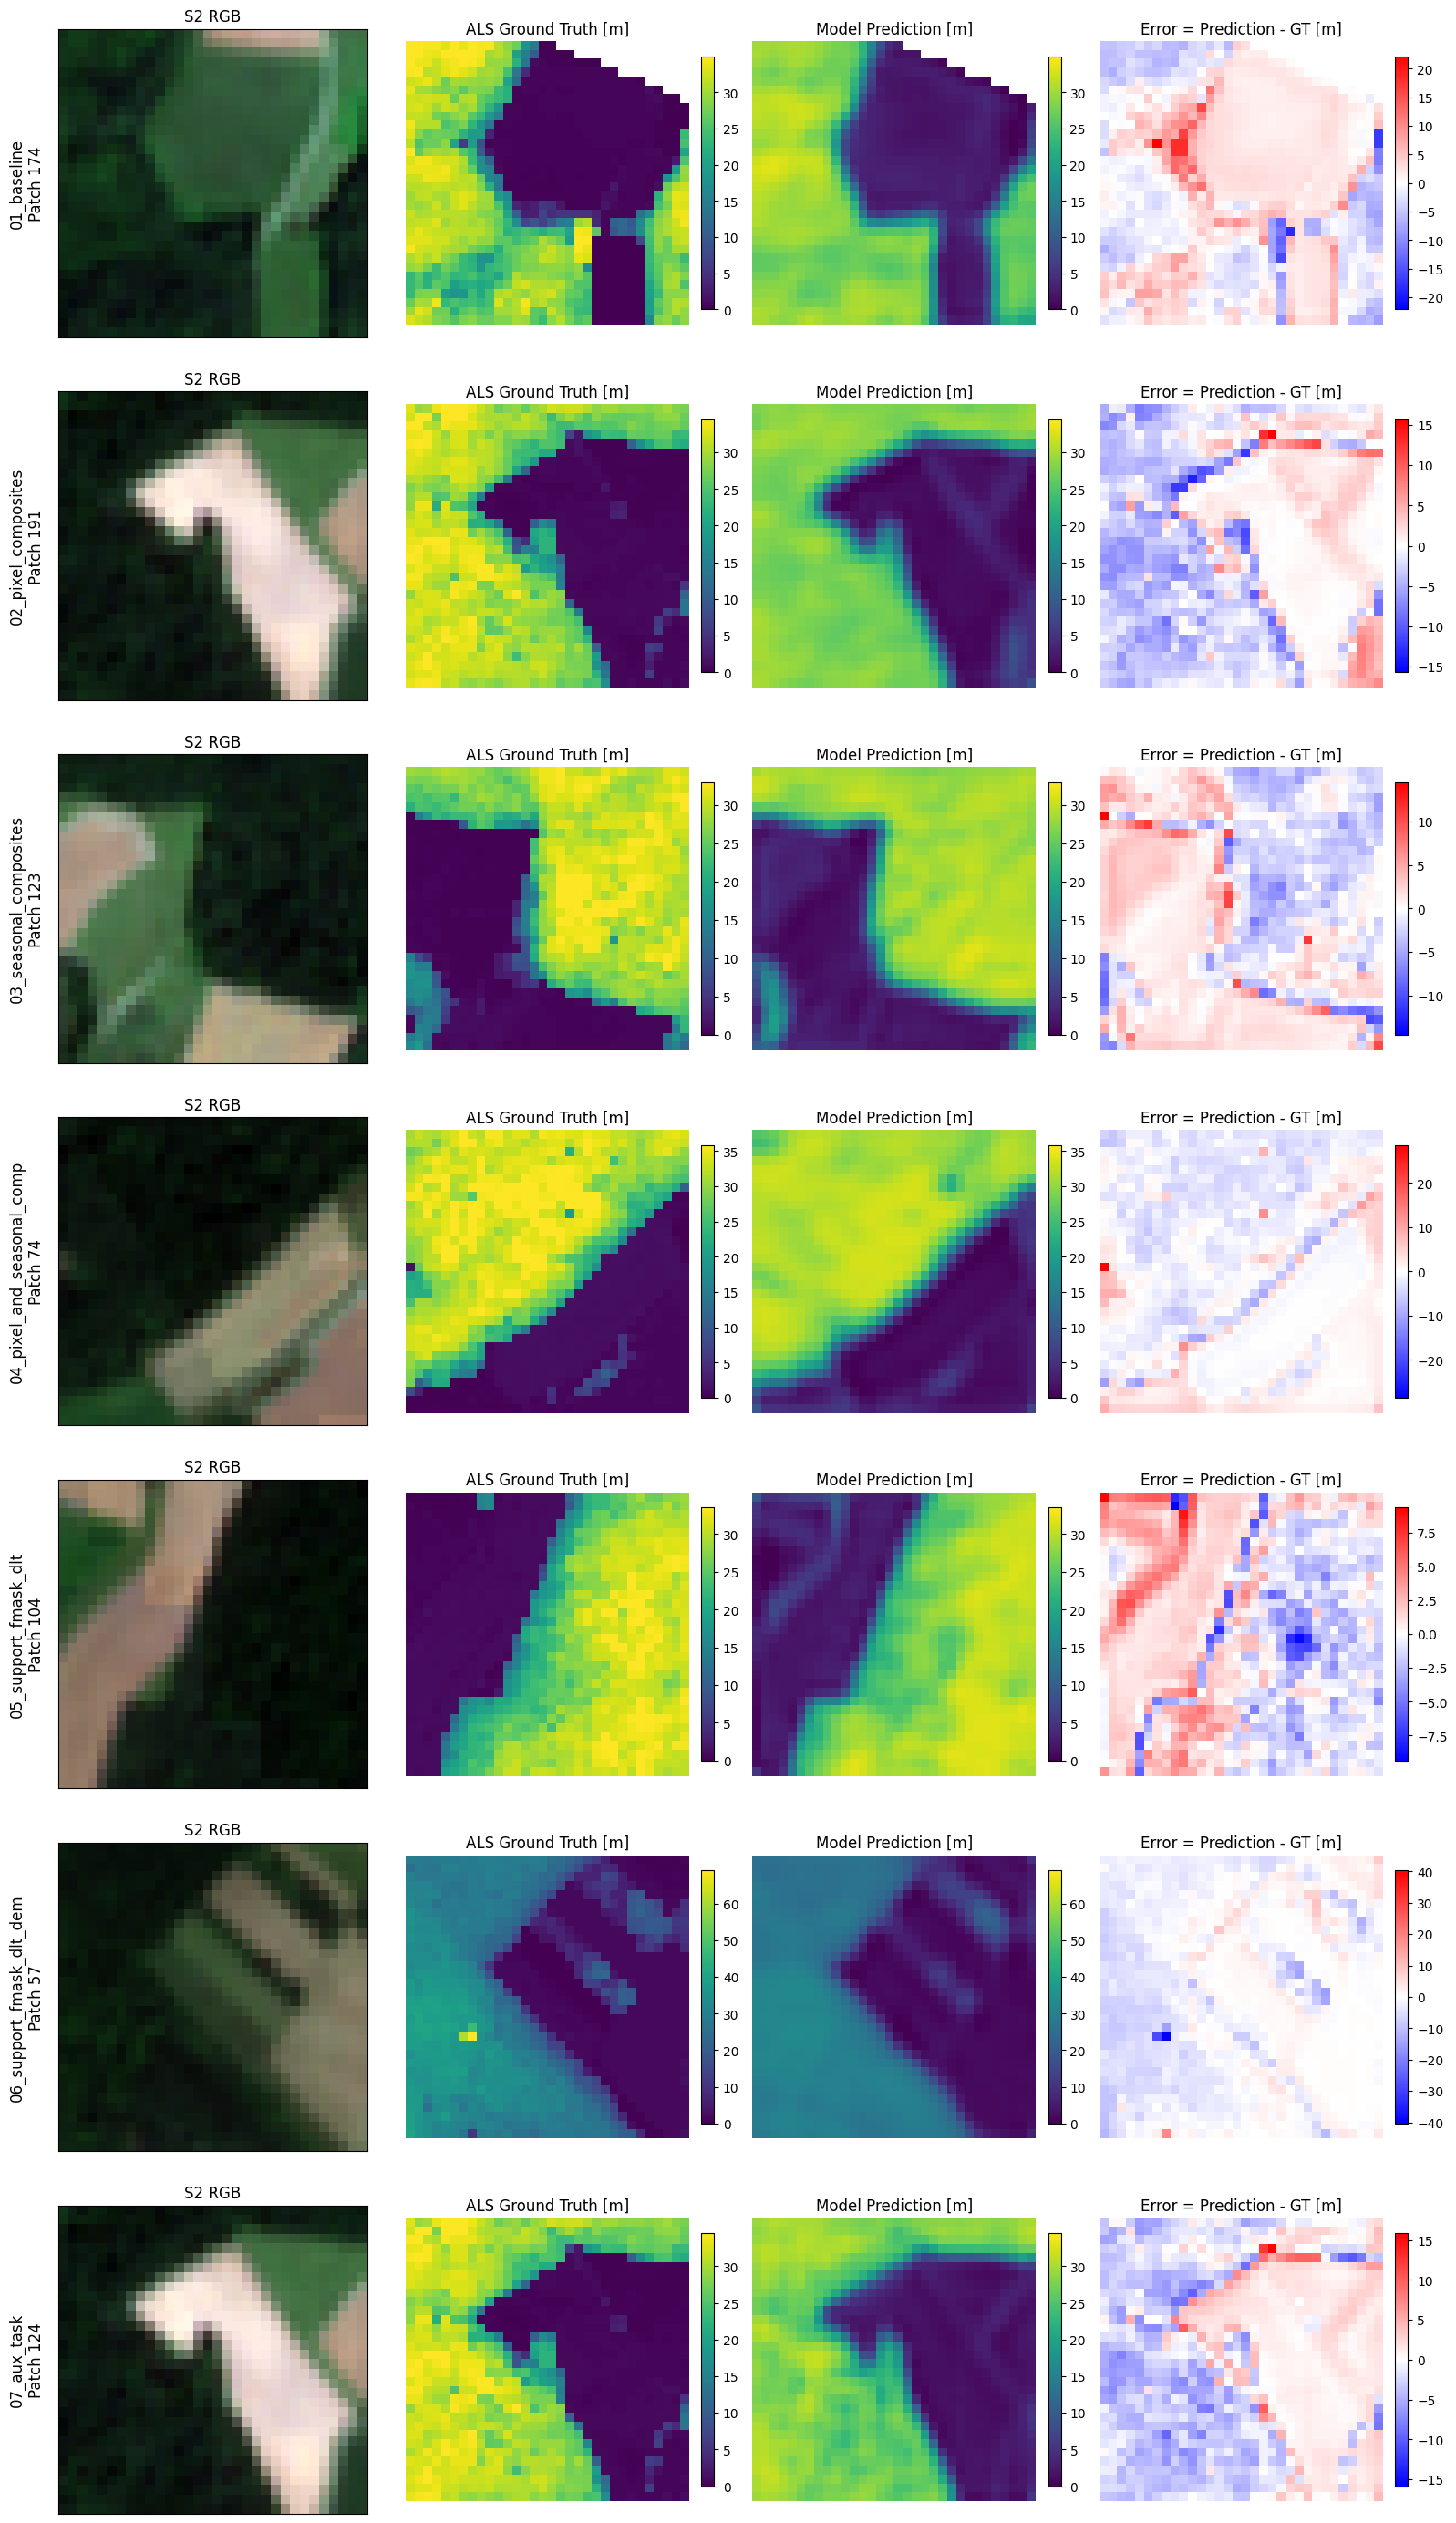

In [80]:
fig = plot_first_n_patches(dfpatch=dftop, n=10)
path = "../results/all_in/good_patches.pdf"
fig.savefig(path)

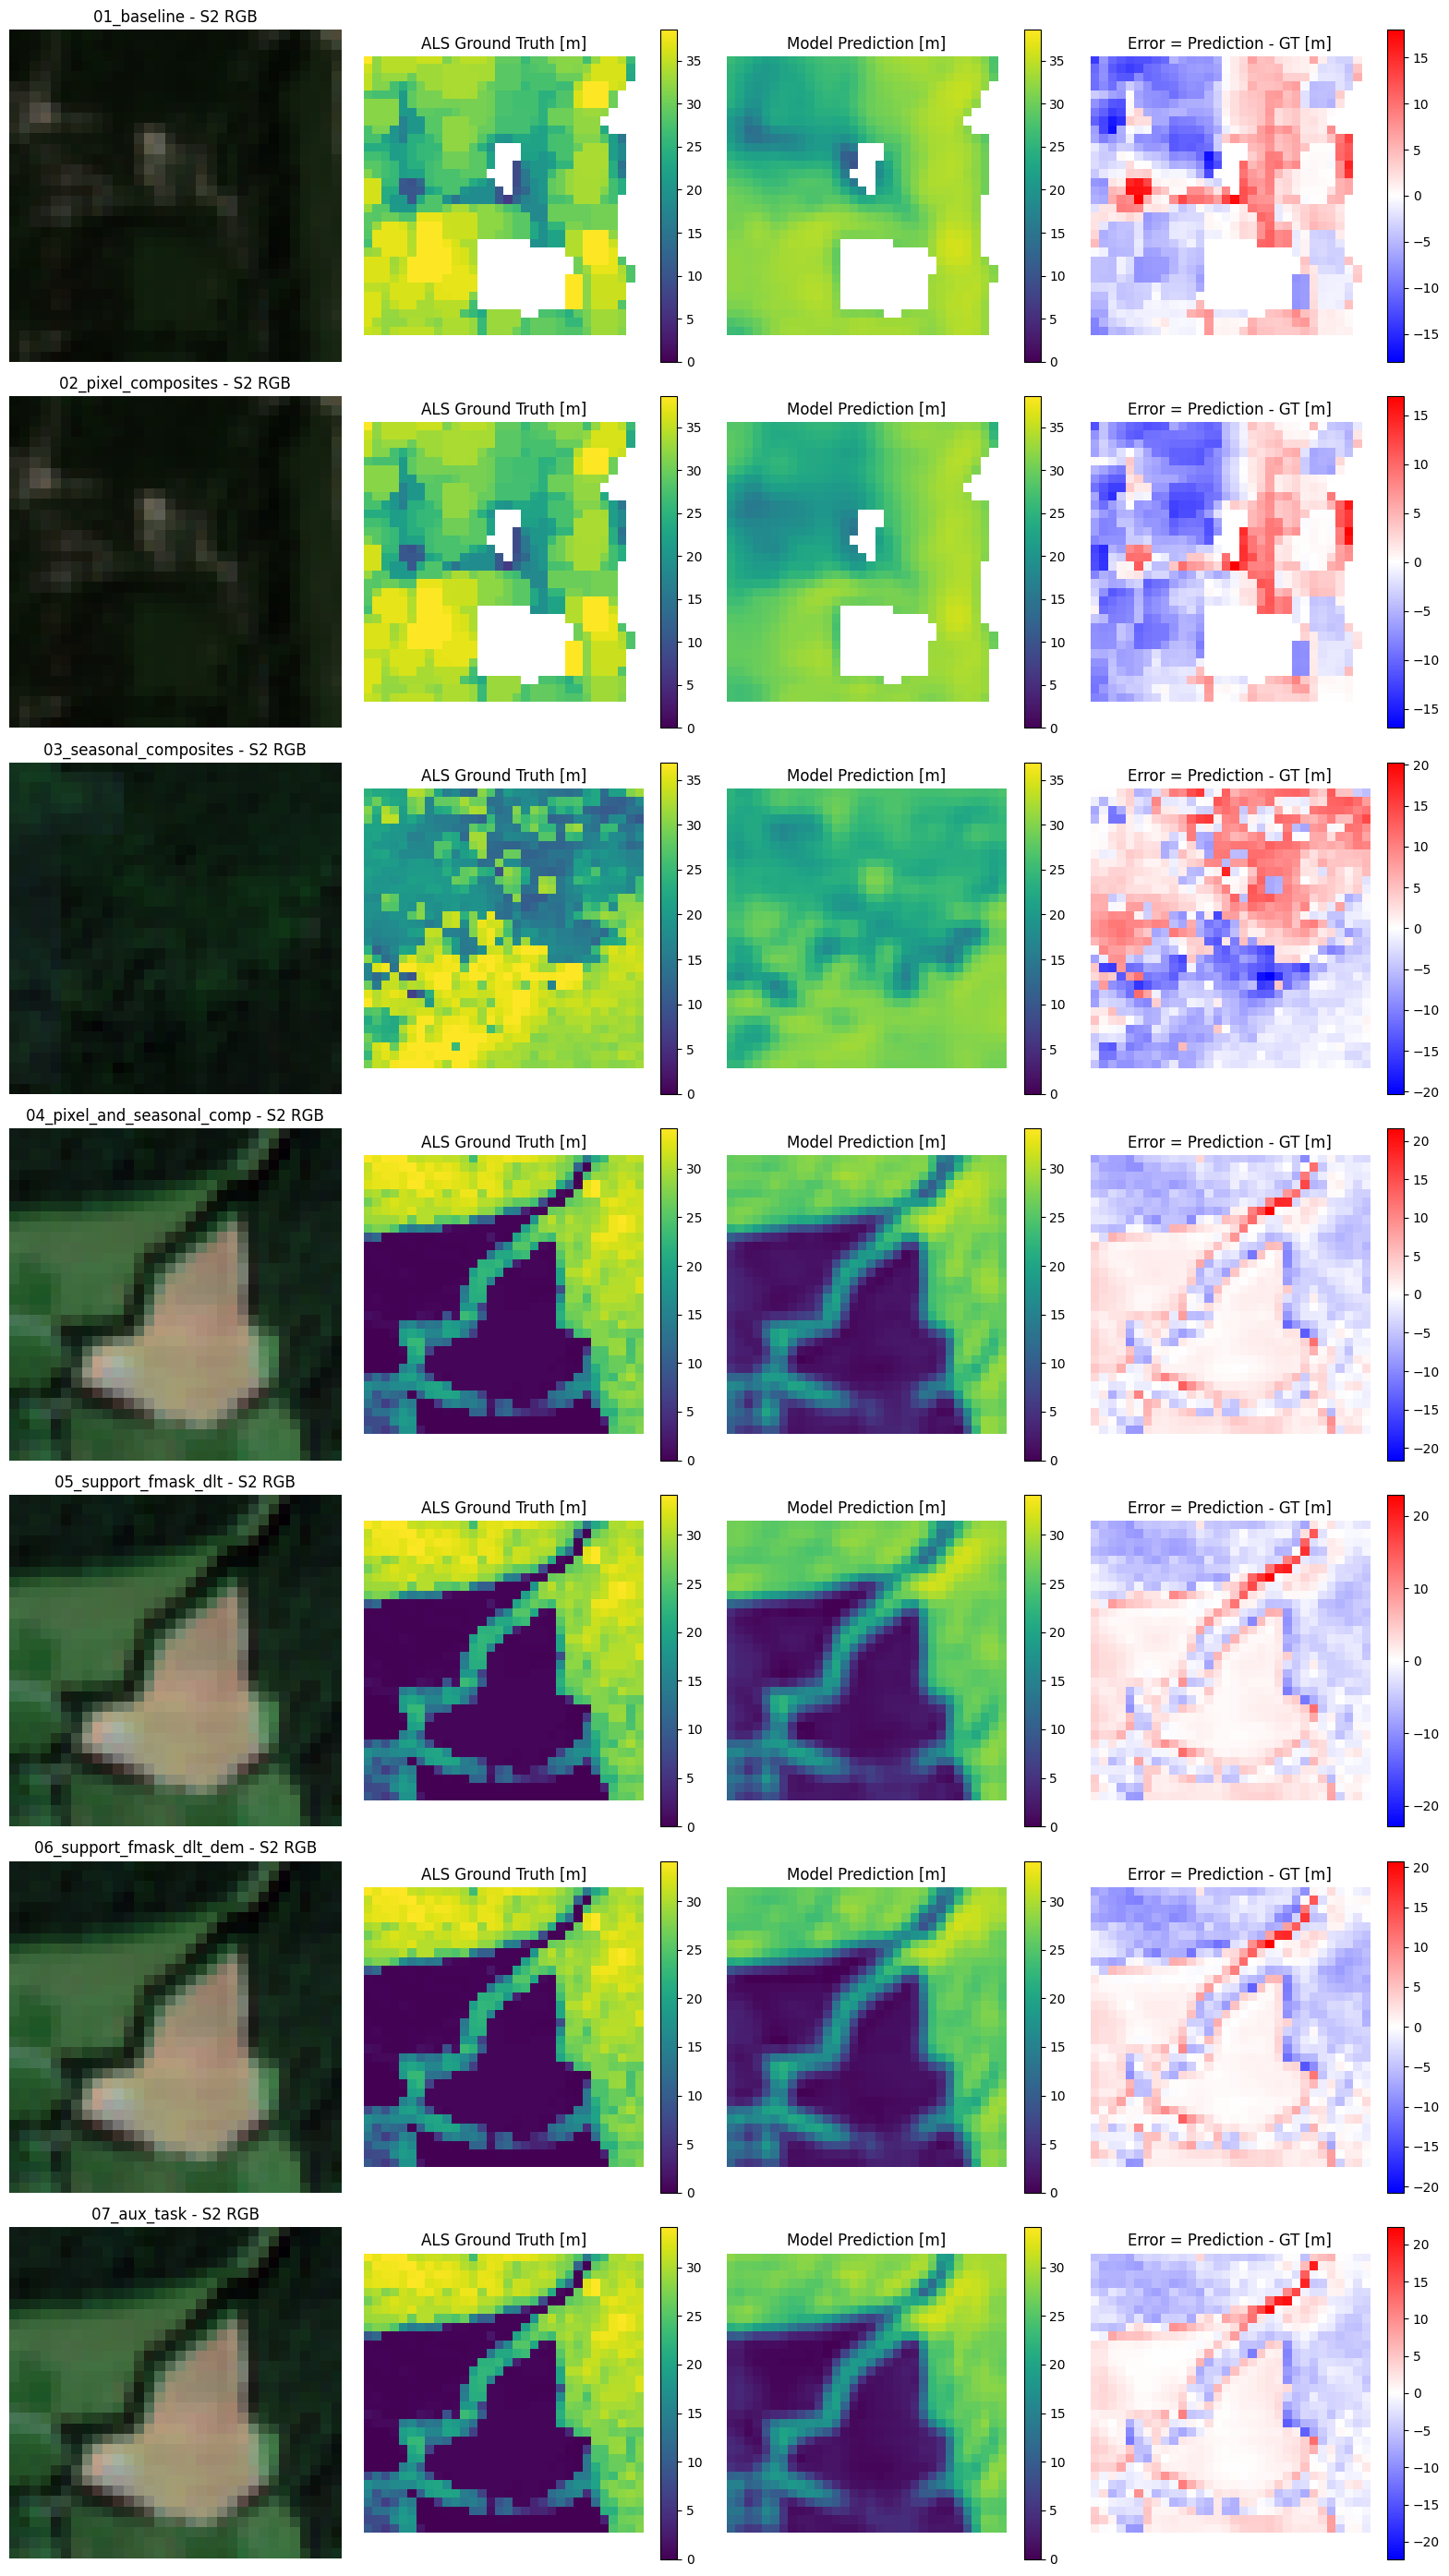

In [591]:
#run_id = 
patch_id = 32
run_id = "251028_PATCHSYNC_0"
plot_patch_across_experiments(dfpatch, run_id, patch_id)